In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
colors = sns.color_palette(as_cmap=True)
cmap = ListedColormap(sns.color_palette()[0:2])

# for 3d plots
import plotly.express as px
import plotly.graph_objects as go


# styling additions
from IPython.display import HTML
style = '''
    <style>
        div.info{
            padding: 15px;
            border: 1px solid transparent;
            border-left: 5px solid #dfb5b4;
            border-color: transparent;
            margin-bottom: 10px;
            border-radius: 4px;
            background-color: #fcf8e3;
            border-color: #faebcc;
        }
        hr{
            border: 1px solid;
            border-radius: 5px;
        }
    </style>'''
HTML(style)

In [63]:
shooting_df = pd.read_csv("/content/24_player_shooting.csv", skiprows=[1])
#https://www.basketball-reference.com/leagues/NBA_2024_shooting.html

In [64]:
#new header should be
new_header = ["Rk", "Player", "Pos", "Age", "Tm", "G", "MP", "FG%", "Dist.", "NA1", "2P%att", "0-3%att", "3-10%att", "10-16%att", "16-3P%att", "3P%att", "NA2", "2P%", "0-3%", "3-10%", "10-16%", "16-3P%", "3P%", "NA3", "2P%ast", "3P%ast", "NA4", "Dunk%att", "Dunk#", "NA5", "Corner%att", "Corner%", "NA6", "HeavesAtt", "HeavesMade", "PlayerID"]

In [65]:
shooting_df.columns = new_header

In [66]:
#variables I want to look at right now (shot-distance)
shot_distance_vars = ["0-3%att", "3-10%att", "10-16%att", "16-3P%att", "3P%att", "Dunk%att", "Corner%att"]

In [67]:
shooting_df[shot_distance_vars]

,0-3%att,3-10%att,10-16%att,16-3P%att,3P%att,Dunk%att,Corner%att
0,0.520,0.215,0.047,0.011,0.207,0.145,0.474
1,0.245,0.367,0.278,0.069,0.041,0.148,0.167
2,0.289,0.176,0.037,0.012,0.487,0.085,0.455
3,0.211,0.188,0.049,0.016,0.535,0.067,0.296
4,0.149,0.145,0.046,0.037,0.623,0.020,0.469
...,...,...,...,...,...,...,...
567,0.528,0.333,0.065,0.009,0.065,0.046,0.571
568,0.121,0.189,0.157,0.067,0.465,0.001,0.053
569,0.332,0.467,0.049,0.022,0.130,0.185,0.458
570,0.661,0.258,0.016,0.016,0.048,0.145,0.000


In [68]:
#cleaning the data

#remove players who haven't played enough games
clean_df = shooting_df[shooting_df["G"] > 30]

#remove all NAs

clean_df = clean_df.dropna(subset = shot_distance_vars)


# My Question

Can we use k-means clusters of shooting patterns and/or position to predict how often a player will score?

**The Clustering Model**

K-Means Clustering

Don't standardize, the data is already pretty standard

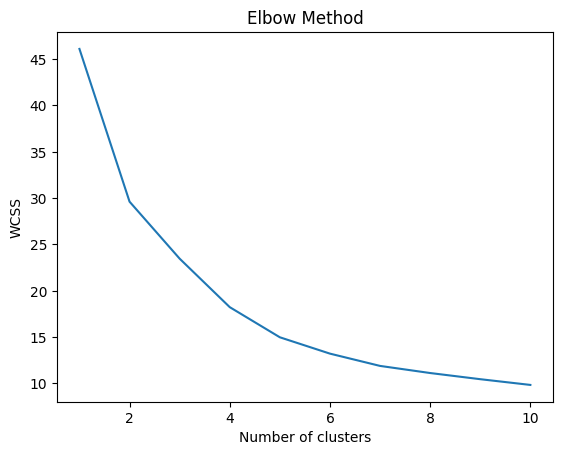

In [69]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming 'shot_distance_vars' is already defined and the data is cleaned in 'clean_df'

# Select the features for clustering
X = clean_df[shot_distance_vars]

# Elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the elbow graph
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

K appears to be 4 or 5

In [70]:
# Create KMeans model
k=5

kmeans = KMeans(n_clusters=k, random_state=0)

# Fit the model to the data
kmeans.fit(X)

# Get the cluster labels
labels = kmeans.labels_

# Create a new DataFrame with the labels
labeled_df = clean_df.copy()
labeled_df['cluster'] = labels

Now that we have clusters, time to explore clusters

In [71]:
#print size of each cluster
labeled_df["cluster"].value_counts()

,count
cluster,
0,127
2,103
4,95
3,38
1,25


In [72]:
for cluster_num in range(k):
  cluster_players = labeled_df[labeled_df['cluster'] == cluster_num]
  sorted_players = cluster_players.sort_values('MP', ascending=False)  # Sort by minutes played
  print(f"Cluster {cluster_num} Players (Sorted by Minutes Played):")
  print(sorted_players['Player'].tolist())
  print("\n")

Cluster 0 Players (Sorted by Minutes Played):
['DeMar DeRozan', 'Coby White', 'Mikal Bridges', 'Paolo Banchero', 'Kevin Durant', 'Dejounte Murray', 'Anthony Edwards', 'Nikola Jokić', 'Jalen Brunson', 'Josh Hart', "De'Aaron Fox", 'Jayson Tatum', 'Austin Reaves', 'Tyrese Maxey', 'Luka Dončić', 'Nikola Vučević', 'Jalen Green', 'Miles Bridges', 'Damian Lillard', 'Shai Gilgeous-Alexander', 'LeBron James', 'Paul George', 'Dennis Schröder', "D'Angelo Russell", 'Devin Booker', 'Jabari Smith Jr.', 'Chet Holmgren', 'Brook Lopez', 'Brandon Miller', 'Tobias Harris', 'Jordan Poole', 'Jaylen Brown', 'Franz Wagner', 'Kawhi Leonard', 'Kyle Kuzma', 'Jrue Holiday', 'Devin Vassell', 'Dillon Brooks', 'Tyrese Haliburton', 'Jalen Williams', 'P.J. Washington', 'Jaden Ivey', 'CJ McCollum', 'Jaren Jackson Jr.', 'Victor Wembanyama', 'Brandon Ingram', 'Scottie Barnes', 'Myles Turner', 'Cam Thomas', 'Collin Sexton', 'Cade Cunningham', 'Terry Rozier', 'Kyrie Irving', 'Karl-Anthony Towns', 'Keyonte George', 'Immanu

These clusters make sense based off who is in them

In [73]:
for cluster_num in range(k):
  cluster_data = labeled_df[labeled_df['cluster'] == cluster_num]
  cluster_averages = cluster_data[shot_distance_vars].mean()
  print(f"Cluster {cluster_num} Averages:")
  print(cluster_averages)
  print("\n")

Cluster 0 Averages:
0-3%att       0.194882
3-10%att      0.214638
10-16%att     0.124055
16-3P%att     0.075370
3P%att        0.390992
Dunk%att      0.031961
Corner%att    0.166394
dtype: float64


Cluster 1 Averages:
0-3%att       0.53248
3-10%att      0.28064
10-16%att     0.05352
16-3P%att     0.01752
3P%att        0.11584
Dunk%att      0.21748
Corner%att    0.66348
dtype: float64


Cluster 2 Averages:
0-3%att       0.138243
3-10%att      0.115825
10-16%att     0.051631
16-3P%att     0.043078
3P%att        0.651233
Dunk%att      0.023563
Corner%att    0.288961
dtype: float64


Cluster 3 Averages:
0-3%att       0.525079
3-10%att      0.305947
10-16%att     0.059789
16-3P%att     0.024395
3P%att        0.084684
Dunk%att      0.207763
Corner%att    0.125737
dtype: float64


Cluster 4 Averages:
0-3%att       0.293674
3-10%att      0.220674
10-16%att     0.066274
16-3P%att     0.032400
3P%att        0.387000
Dunk%att      0.074842
Corner%att    0.438558
dtype: float64




In [74]:
cluster_pos_counts = labeled_df.groupby(['Pos', 'cluster'])['Player'].count().reset_index()
pos_counts = labeled_df.groupby('Pos')['Player'].count().reset_index()
merged_df = pd.merge(cluster_pos_counts, pos_counts, on='Pos')

#removing niche positions
merged_df = merged_df[merged_df['Player_y'] > 10]


pivot_table = pd.pivot_table(merged_df, values='Player_x', index='Pos', columns='cluster', aggfunc='sum', fill_value=0)
print(pivot_table)

cluster   0   1   2   3   4
Pos                        
C        15  11   4  32   4
PF       18   8  17   4  29
PG       44   1  13   0   7
SF       19   2  32   2  31
SG       26   1  36   0  21


**Cluster Descriptions**

Cluster Zero: Point-Guard-ish players


*   Shoot about 39% of their shots from behind the arc,about the same as cluster 4
*   Shoot the most of any group from midrange


Cluster One: Corner-Three Bigs


*   Shoot most of their shots right by the basket
*   Take 11.58% of their shots from 3, of those 66% are corner threes

Cluster Two: Three-point shooters


*   Take by far the most 3s of any cluster at about 65%
*   Generally avoid the midrange, but shoot about 22% of their shots from 0 to 10 feet

Cluster Three: Star Bigs


*   Shoot most of their shots right by the basket
*   Take 8.4% of their shots from 3, of those only 12% are corner threes

Cluster Four: Efficiency Kings


*   Shoot about 29.3%  of their shots right by the rim
*   Take 38.7% of their shots from 3
*   Threes and shots in the paint are considered the most efficient shots, so these guys are likely putting up the most points per shot attempt


# The Prediction Model

I want to use these clusters, as well as player position, to predict the amount of points a player will score. To make things fair to bench players, I will use points per 36 minutes rather than points per game, but I will also require all players in the model to play over 8 minutes per game.

In [79]:
per36df = pd.read_csv("/content/24_NBAper36.csv")

In [81]:
#renaming weirdly named columns
per36df = per36df.rename(columns={"Player▲": "Player", "Player▲-additional": "PlayerID"})


In [83]:
#removing the players who don't play that much

per36df = per36df[per36df["G"] > 25]

In [89]:
#take the columns I actually want

per36tolook = ["Player", "PlayerID", "Pos", "PTS"]

per36df[per36tolook]

,Player,PlayerID,Pos,PTS
0,Precious Achiuwa,achiupr01,PF,12.5
1,Bam Adebayo,adebaba01,C,20.4
2,Ochai Agbaji,agbajoc01,SG,10.0
3,Santi Aldama,aldamsa01,PF,14.6
4,Nickeil Alexander-Walker,alexani01,SG,12.3
...,...,...,...,...
567,Thaddeus Young,youngth01,PF,11.2
568,Trae Young,youngtr01,PG,25.7
569,Omer Yurtseven,yurtsom01,C,14.7
570,Cody Zeller,zelleco01,C,8.6


In [90]:
#combining per36df[per36tolook] and the clusters from merged_df into a new df fulldf

fulldf = pd.merge(per36df[per36tolook], labeled_df[['PlayerID', 'cluster']], on='PlayerID', how='left')


In [91]:
fulldf

,Player,PlayerID,Pos,PTS,cluster
0,Precious Achiuwa,achiupr01,PF,12.5,1.0
1,Bam Adebayo,adebaba01,C,20.4,3.0
2,Ochai Agbaji,agbajoc01,SG,10.0,4.0
3,Santi Aldama,aldamsa01,PF,14.6,2.0
4,Nickeil Alexander-Walker,alexani01,SG,12.3,2.0
...,...,...,...,...,...
405,Thaddeus Young,youngth01,PF,11.2,1.0
406,Trae Young,youngtr01,PG,25.7,0.0
407,Omer Yurtseven,yurtsom01,C,14.7,1.0
408,Cody Zeller,zelleco01,C,8.6,3.0


In [93]:
#adding pts_cat

# Define the bins and labels for the categories
bins = [0, 5, 10, 15, 20, 25, float('inf')]
labels = ['<5', '5-10', '10-15', '15-20', '20-25', '>25']

# Create the 'pts_cat' column using pd.cut
fulldf['pts_cat'] = pd.cut(fulldf['PTS'], bins=bins, labels=labels, right=False)

In [94]:
fulldf

,Player,PlayerID,Pos,PTS,cluster,pts_cat
0,Precious Achiuwa,achiupr01,PF,12.5,1.0,10-15
1,Bam Adebayo,adebaba01,C,20.4,3.0,20-25
2,Ochai Agbaji,agbajoc01,SG,10.0,4.0,10-15
3,Santi Aldama,aldamsa01,PF,14.6,2.0,10-15
4,Nickeil Alexander-Walker,alexani01,SG,12.3,2.0,10-15
...,...,...,...,...,...,...
405,Thaddeus Young,youngth01,PF,11.2,1.0,10-15
406,Trae Young,youngtr01,PG,25.7,0.0,>25
407,Omer Yurtseven,yurtsom01,C,14.7,1.0,10-15
408,Cody Zeller,zelleco01,C,8.6,3.0,5-10


Using a Random Forest model to predict points based off cluster and position. I'm choosing a Random Forest model, because these models are good at taking both quantitative and categorical data to make predictions. In this case, I'm just using categorical data, so I'm not sure how successful it'll be at predicting a more quantitative variable. The two independent variables will be cluster and position, and the dependent variable will be points per 36 minutes. Because we are using a random forest model, I am splitting the points scored into 6 categories.

In [95]:
#splitting into train and test
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_data, test_data = train_test_split(fulldf, test_size=0.2, random_state=42)

In [104]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#training the random forest model


# Create a RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Prepare the features (X) and target (y)
X_train = train_data[['cluster', 'Pos']]
y_train = train_data['pts_cat']
X_test = test_data[['cluster', 'Pos']]
y_test = test_data['pts_cat']

# Convert categorical features to numerical using one-hot encoding
X_train = pd.get_dummies(X_train, columns=['Pos'], prefix='Pos')
X_test = pd.get_dummies(X_test, columns=['Pos'], prefix='Pos')

# Align the columns of X_test with X_train in case there are missing columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Random Forest Classifier: {accuracy}")

Accuracy of the Random Forest Classifier: 0.4268292682926829


This model is absolutely horrible. The further I got through this project, the more I didn't really think it would be great. But this was even worse than I expected. There seems to be no predictive quality to these shooting clusters I found. In fact, the accuracy score of .4268 is worse than random. I'm going to try Random Forest regression instead, and see if it could be a little more accurate.

In [105]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Create a RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Prepare the features (X) and target (y)
X_train = train_data[['cluster', 'Pos']]
y_train = train_data['PTS']
X_test = test_data[['cluster', 'Pos']]
y_test = test_data['PTS']

# Convert categorical features to numerical using one-hot encoding
X_train = pd.get_dummies(X_train, columns=['Pos'], prefix='Pos')
X_test = pd.get_dummies(X_test, columns=['Pos'], prefix='Pos')

# Align the columns of X_test with X_train
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Train the regressor
rf_regressor.fit(X_train, y_train)

# Make predictions
y_pred = rf_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error of the Random Forest Regressor: {mse}")

Mean Squared Error of the Random Forest Regressor: 18.612890965708118


In [107]:
# Make predictions using the trained regressor
y_pred = rf_regressor.predict(X_test)

# Define the bins and labels for the categories (same as before)
bins = [0, 5, 10, 15, 20, 25, float('inf')]
labels = ['<5', '5-10', '10-15', '15-20', '20-25', '>25']

# Convert predicted points to categories
y_pred_cat = pd.cut(y_pred, bins=bins, labels=labels, right=False)

# Convert actual points to categories (if not already done)
y_test_cat = pd.cut(y_test, bins=bins, labels=labels, right=False)

# Calculate the accuracy
accuracy = accuracy_score(y_test_cat, y_pred_cat)
print(f"Accuracy of the Random Forest Regressor (Categorical): {accuracy}")

Accuracy of the Random Forest Regressor (Categorical): 0.4146341463414634


The regression model is as bad, if not worse than the random forest classifier. With only a few categories in these categorical variables, this was likely a doomed idea from the start. These clusters, while telling about the different types of players, don't offer much predictive usefulness. However, I now want to see if they are better than position at making these predictions. (they will both be bad)

In [108]:
#training the random forest model


# Create a RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Prepare the features (X) and target (y)
X_train = train_data[['cluster']]
y_train = train_data['pts_cat']
X_test = test_data[['cluster']]
y_test = test_data['pts_cat']


# Align the columns of X_test with X_train in case there are missing columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Random Forest Classifier: {accuracy}")

Accuracy of the Random Forest Classifier: 0.4268292682926829


In [109]:
#training the random forest model


# Create a RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Prepare the features (X) and target (y)
X_train = train_data[['Pos']]
y_train = train_data['pts_cat']
X_test = test_data[['Pos']]
y_test = test_data['pts_cat']

# Convert categorical features to numerical using one-hot encoding
X_train = pd.get_dummies(X_train, columns=['Pos'], prefix='Pos')
X_test = pd.get_dummies(X_test, columns=['Pos'], prefix='Pos')

# Align the columns of X_test with X_train in case there are missing columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Random Forest Classifier: {accuracy}")

Accuracy of the Random Forest Classifier: 0.3902439024390244


Interestingly, the clusters I found seem to be a better predictor of points scored than their traditional position, albeit not a huge amount. There are many more factors involved in the amount of points that players score than just how they play the game.

Ultimately, the only productive part of this excercise has been the clusters themselves, so I will once again describe them in this conclusion.

In [111]:
for cluster_num in range(k):
  cluster_players = fulldf[fulldf['cluster'] == cluster_num]
  sorted_players = cluster_players.sort_values('PTS', ascending=False)  # Sort by minutes played
  print(f"Cluster {cluster_num} Players (Sorted by Minutes Played):")
  print(sorted_players['Player'].tolist())
  print("\n")

Cluster 0 Players (Sorted by Minutes Played):
['Joel Embiid', 'Luka Dončić', 'Shai Gilgeous-Alexander', 'Jalen Brunson', 'Nikola Jokić', 'Donovan Mitchell', 'Devin Booker', 'Jayson Tatum', "De'Aaron Fox", 'Anthony Edwards', 'Kyrie Irving', 'Kevin Durant', 'LeBron James', 'Victor Wembanyama', 'Trae Young', 'Cam Thomas', 'Collin Sexton', 'Lauri Markkanen', 'Jaren Jackson Jr.', 'Kawhi Leonard', 'Desmond Bane', 'Tyrese Maxey', 'Damian Lillard', 'Jaylen Brown', 'Kyle Kuzma', 'Cade Cunningham', 'Kristaps Porziņģis', 'Julius Randle', 'Jamal Murray', 'Karl-Anthony Towns', 'Paul George', 'Cam Whitmore', 'Anfernee Simons', 'Paolo Banchero', 'Brandon Ingram', 'DeMar DeRozan', 'Myles Turner', 'Dejounte Murray', 'Tyrese Haliburton', 'Tyler Herro', 'Jalen Green', 'CJ McCollum', 'Franz Wagner', 'Jalen Williams', 'Malik Monk', 'Terry Rozier', 'Devin Vassell', 'Bojan Bogdanović', 'Immanuel Quickley', 'Jordan Poole', 'Jalen Smith', 'Scottie Barnes', 'GG Jackson II', 'T.J. McConnell', 'Mikal Bridges', 'J

# Clusters

**Point-Guard-ish players**


*   Shoot about 39% of their shots from behind the arc,about the same as cluster 4
*   Shoot the most of any group from midrange
*   Embiid, Luka, Shai, Jokic, Booker, KD, Lebron, Wembanyama
*   Most of your MVP candidates fall here


**Corner-Three Bigs**


*   Shoot most of their shots right by the basket
*   Take 11.58% of their shots from 3, of those 66% are corner threes
*   Evan Mobley, Aaron Gordon, Derrick Lively II, Thanasis Antetokounmpo

**Three-point shooters**


*   Take by far the most 3s of any cluster at about 65%
*   Generally avoid the midrange, but shoot about 22% of their shots from 0 to 10 feet
*   Steph, Klay, Donte DiVincenzo, Micheal Porter Jr.

**Star Bigs**


*   Shoot most of their shots right by the basket
*   Take 8.4% of their shots from 3, of those only 12% are corner threes
*   Giannis,  Zion, Anthony Davis, Alperen Sengun, Jonathon Kuminga

**Efficiency Kings**


*   Shoot about 29.3%  of their shots right by the rim
*   Take 38.7% of their shots from 3
*   Threes and shots in the paint are considered the most efficient shots, so these guys are likely putting up the most points per shot attempt
*   Paskal Siakam,  RJ Barrett, Jimmy Buttler, DeAndre Ayton, Kelly Oubre Jr., Russel Westbrook


The only thing worth taking away from this project are these clusters, which do seem to point to some clear trends in the modern NBA. Even then, I think these clusters could be better, although I'm not quite sure how I could make them better. There is likely far more research which can be done into player's shooting splits. Additionally, these players do not exist in vacuums, and it could be interesting to see if roster creation dictates these shooting splits or if these shooting splits dictate the roster. Do players shoot differently depending on the shooting splits of their other teammates on the floor? Do they shoot differently depending on who's on the other team?